In [74]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.textpath import TextPath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn import mixture

In [9]:
#vereinfachte Methode:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

In [3]:
df = pd.read_csv('../dataset/movies.csv')
#dfs ist ein Verweis auf den ganzen Dataframe, weil df im folgenden gesliced wird
dfs = df.sample(frac=1)
dfs.shape

(3729, 26)

In [3]:
#df.dropna(subset=['text', 'genre', 'year', 'production_region'], inplace=True)
dfs.drop_duplicates(subset=['IMDB_ID'], inplace=True)
dfs.shape
df.drop_duplicates(subset=['IMDB_ID'], inplace=True)
dfs.shape

(6832110, 19)

In [4]:
dfs.head()

,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
6789126,NaN,NaN,tt4347046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tvEpisode,Episode #1.7,Episode #1.7,0.0,NaN,NaN,NaN,NaN,NaN
5961590,NaN,NaN,tt3180256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tvEpisode,Episode dated 19 September 2013,Episode dated 19 September 2013,0.0,2013.0,NaN,NaN,NaN,NaN
1427061,NaN,NaN,tt0881571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tvEpisode,Episode dated 11 October 2006,Episode dated 11 October 2006,0.0,2006.0,NaN,NaN,NaN,NaN
5033744,NaN,NaN,tt2118773,NaN,NaN,NaN,NaN,NaN,nm0040801,NaN,tvMovie,"Young, Foreign and Over Here","Young, Foreign and Over Here",0.0,2011.0,NaN,60,NaN,NaN
3535642,NaN,NaN,tt12126012,NaN,NaN,NaN,NaN,NaN,nm6657078,NaN,tvEpisode,Episode #1.3,Episode #1.3,0.0,2020.0,NaN,NaN,8.7,6.0


# Clustering über Zeit mit Embeddings

In [4]:
from pathlib import Path
import numpy as np
def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >=2 :
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [5]:
filenames, embeddings = read_embeddings('../dataset/embeddings.txt')

In [6]:
filenames.shape, embeddings.shape

((3729,), (3729, 300))

In [7]:
df = df[df['filename'].isin(filenames)].copy()
df.shape

(3729, 19)

In [8]:
(df.filename == filenames).all()

True

In [9]:
#Einfügen der Embeddings ins Dataframe
df['embedding'] = [e for e in embeddings]
df.shape

(3729, 20)

## Plot über Zeit

Mean:  2012.2115848753017 Median:  2012.0


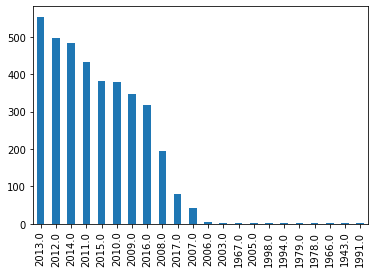

In [10]:
pd.value_counts(df['year']).plot.bar()
print('Mean: ', df['year'].mean(), 'Median: ', df['year'].median())

## Split der Daten in Zeitperioden

In [11]:
#sincevalue = 2017
#beforevalue = 2000
#since = df.year >= sincevalue
#before = df.year <= beforevalue
#years = since + before
#years.shape
colorlist = []

for x in df.year:
    if x >=2017:
        colorlist.append('red')
    elif x <= 2007:
        colorlist.append('blue')
    else: 
        colorlist.append('white')

C:\Users\janko\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [12]:
df['labelcolor']=colorlist

## K-Means

In [13]:
model = KMeans(n_clusters=2)
model.fit(embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [129]:
len(model.labels_)

3729

## PCA

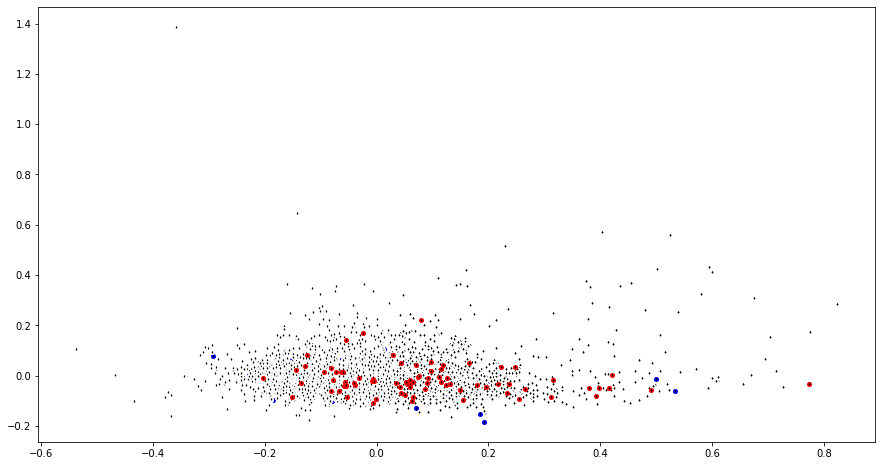

In [15]:
pca = PCA(n_components=2)
pca.fit(embeddings)
X_tf = pca.transform(embeddings)

#Abspeichern der Zwischenergebnisste im Datafram
df['pca2d_1'] = X_tf[:,0]
df['pca2d_2'] = X_tf[:,1]
df['kmeans'] = model.labels_

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in df.iterrows():
    x = d[1].pca2d_1
    y = d[1].pca2d_2    
    plt.plot(x, y, 'o', markersize=4, color= d[1].labelcolor)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeans}'), color='black', markersize=1)


3729


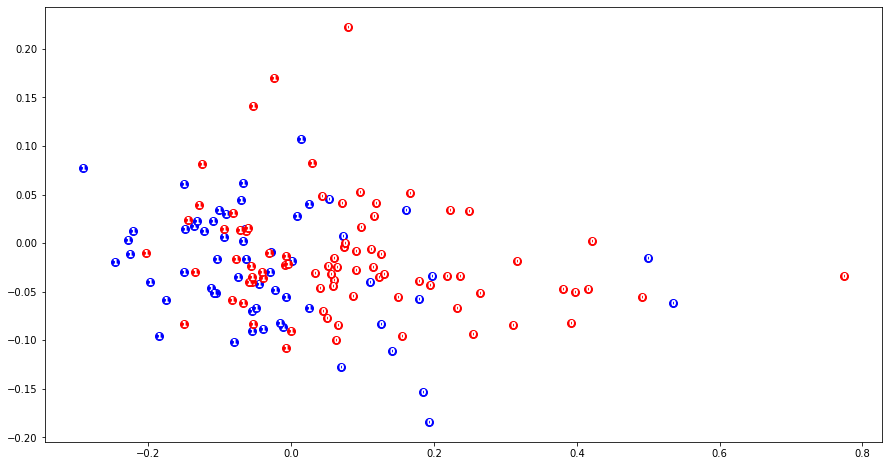

In [16]:
pca = PCA(n_components=2)
pca.fit(embeddings)
X_tf = pca.transform(embeddings)
print(len(X_tf))
df['pca2d_1'] = X_tf[:,0]
df['pca2d_2'] = X_tf[:,1]
df['kmeans'] = model.labels_

df_clean = df[df.labelcolor != 'white']
#df_embedding = df_clean['embedding']
#df_embedding.tolist()

plt.figure(figsize=(15,8))
for d in df_clean.iterrows():
    x = d[1].pca2d_1
    y = d[1].pca2d_2    
    plt.plot(x, y, 'o', markersize=8, color= d[1].labelcolor)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeans}'), color='white', markersize=6)


### Verteilung der Ergebnisse

In [17]:
b1 = df.loc[(df['kmeans'] == 1) & (df['labelcolor'] == 'blue')]
b0 = df.loc[(df['kmeans'] == 0) & (df['labelcolor'] == 'blue')]
r1 = df.loc[(df['kmeans'] == 1) & (df['labelcolor'] == 'red')]
r0 = df.loc[(df['kmeans'] == 0) & (df['labelcolor'] == 'red')]
print('b1: ', len(b1), 'b0: ', len(b0), 'r1: ', len(r1), 'r0: ', len(r0))

b1:  45 b0:  13 r1:  30 r0:  50


# Ohne Embeddings

# Zwei Cluster

(15945, 19)

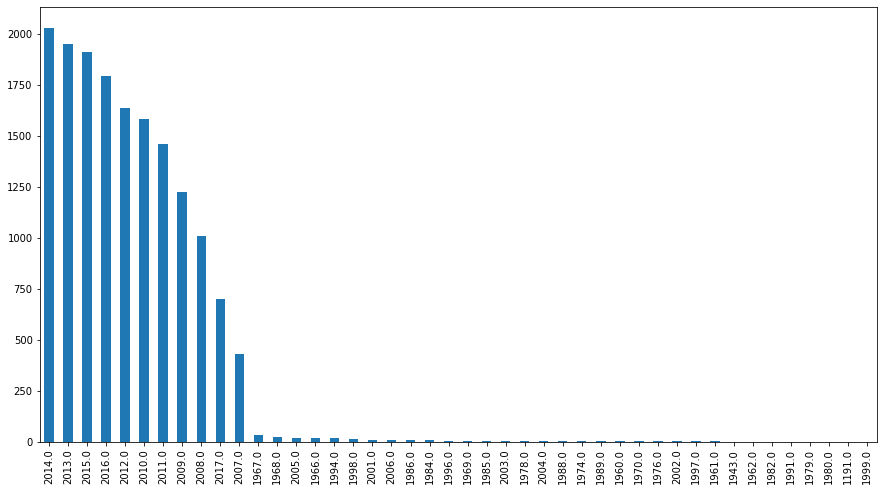

In [77]:
dfs.dropna(subset=['text', 'year', 'genre', 'duration', 'runtimeMinutes'], inplace=True)
plt.figure(figsize=(15,8))
pd.value_counts(dfs['year']).plot.bar()
dfs.shape

# Einschub Titletype - Was ist in Filme enthalten?

## Movie VS. TVMovie

In [ ]:
# remove "ein Netflix Original" 

tvEpisode       13154
movie            3722
tvMovie           355
video             133
short              71
tvMiniSeries       16
tvSeries           15
tvSpecial          14
tvShort             7
Name: titleType, dtype: int64

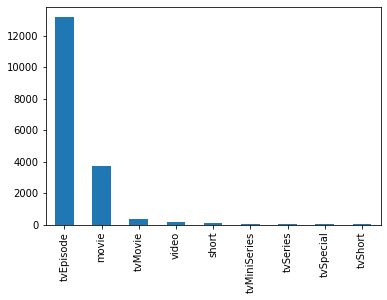

In [31]:
pd.value_counts(dfs['titleType']).plot.bar()
pd.value_counts(dfs['titleType'])

## Movie

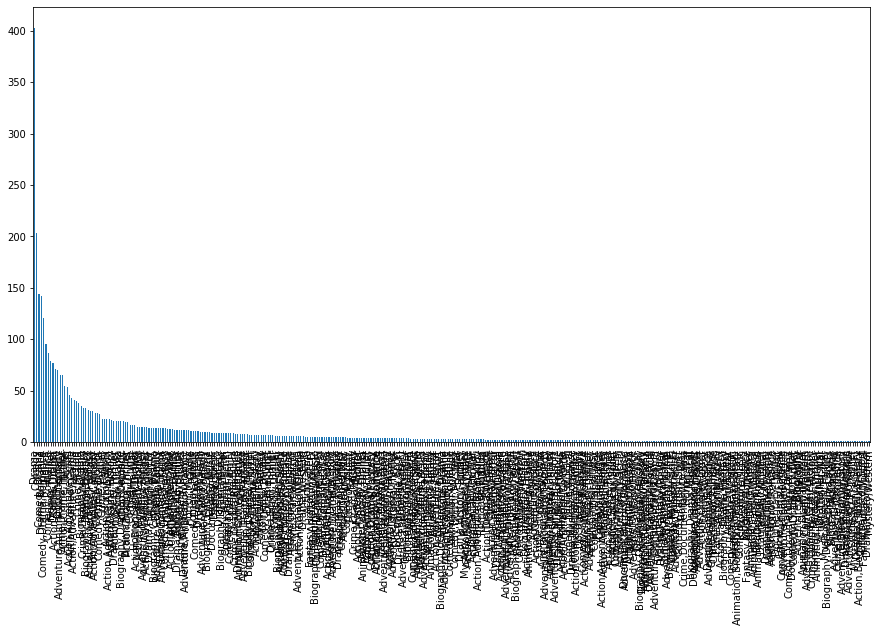

In [57]:
dfs_movie = dfs.loc[dfs['titleType'] == 'movie']
dfs_movie.shape
plt.figure(figsize=(15,8))
pd.value_counts(dfs_movie['genre']).plot.bar()

In [71]:
from collections import Counter
genre_combination_frequs = Counter(dfs_movie.genre)
genre_combination_frequs.most_common(20)
#len(genre_combination_frequs)

[('Drama', 403),
 ('Comedy', 203),
 ('Comedy,Drama', 144),
 ('Drama,Romance', 142),
 ('Comedy,Drama,Romance', 121),
 ('Horror', 95),
 ('Comedy,Romance', 87),
 ('Horror,Thriller', 79),
 ('Drama,Thriller', 77),
 ('Action,Crime,Drama', 71),
 ('Documentary', 70),
 ('Adventure,Animation,Comedy', 65),
 ('Crime,Drama,Thriller', 65),
 ('Action,Crime,Thriller', 54),
 ('Thriller', 53),
 ('Action,Adventure,Sci-Fi', 46),
 ('Action,Comedy,Crime', 43),
 ('Action,Adventure,Drama', 41),
 ('Action', 40),
 ('Crime,Drama', 38)]

In [59]:
pd.value_counts(dfs_movie['genre'])

Drama                           403
Comedy                          203
Comedy,Drama                    144
Drama,Romance                   142
Comedy,Drama,Romance            121
                               ... 
Action,Biography,Documentary      1
Drama,History,Sport               1
Family,Fantasy,Musical            1
Drama,History,Horror              1
Mystery,Western                   1
Name: genre, Length: 358, dtype: int64

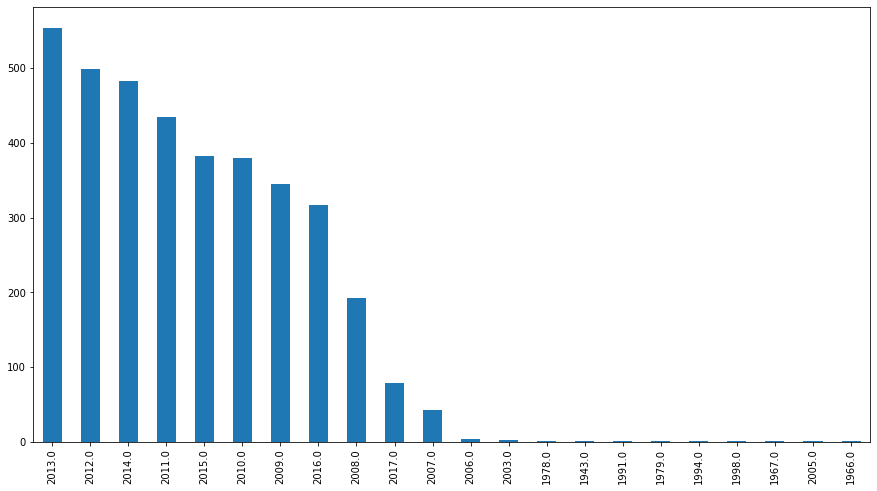

In [37]:
plt.figure(figsize=(15,8))
pd.value_counts(dfs_movie['year']).plot.bar()

# TV Movie

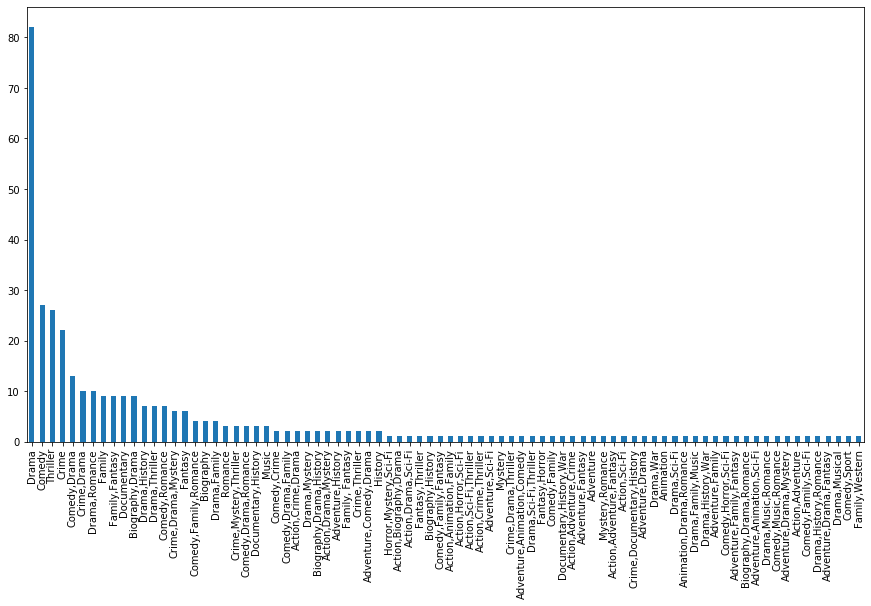

In [34]:
dfs_tvmovie = dfs.loc[dfs['titleType'] == 'tvMovie']
dfs_tvmovie
plt.figure(figsize=(15,8))
pd.value_counts(dfs_tvmovie['genre']).plot.bar()

In [62]:
from collections import Counter
genre_combination_frequs = Counter(dfs_tvmovie.genre)
genre_combination_frequs.most_common(20)

[('Drama', 82),
 ('Comedy', 27),
 ('Thriller', 26),
 ('Crime', 22),
 ('Comedy,Drama', 13),
 ('Drama,Romance', 10),
 ('Crime,Drama', 10),
 ('Family,Fantasy', 9),
 ('Documentary', 9),
 ('Biography,Drama', 9),
 ('Family', 9),
 ('Drama,History', 7),
 ('Drama,Thriller', 7),
 ('Comedy,Romance', 7),
 ('Fantasy', 6),
 ('Crime,Drama,Mystery', 6),
 ('Biography', 4),
 ('Comedy,Family,Romance', 4),
 ('Drama,Family', 4),
 ('Romance', 3)]

(2640, 19)

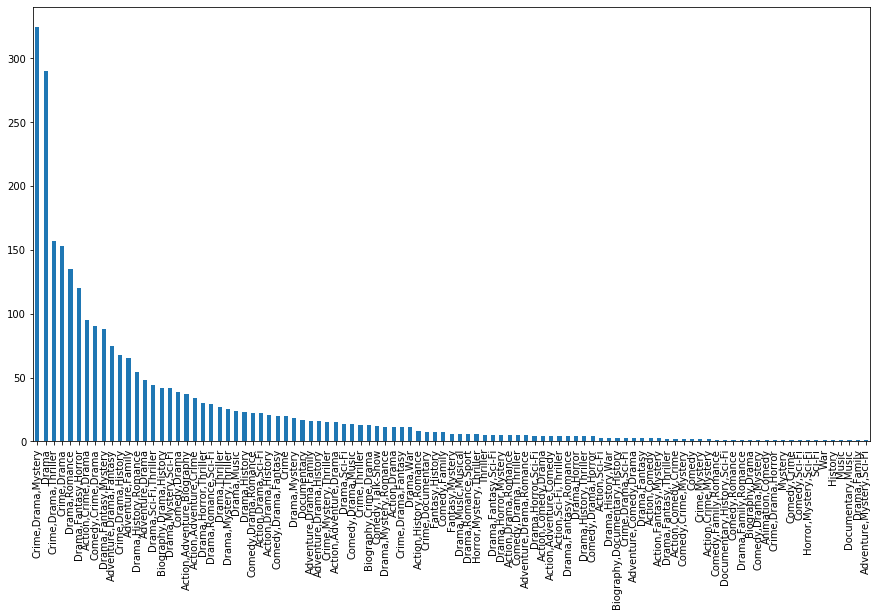

In [78]:
dfs_series_long = dfs.loc[(dfs['titleType'] == 'tvEpisode') & (dfs['runtimeMinutes'].astype('int') >= 50)]
dfs_series_long
plt.figure(figsize=(15,8))
pd.value_counts(dfs_series_long['genre']).plot.bar()
dfs_series_long.shape

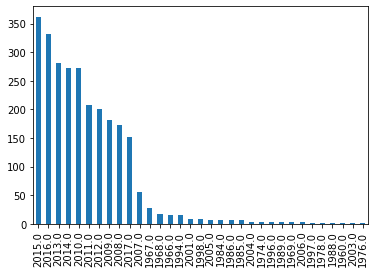

In [79]:
pd.value_counts(dfs_series_long['year']).plot.bar()

## Slicing 2 Cluster Datensatz

red     4294
blue    3636
Name: colors, dtype: int64

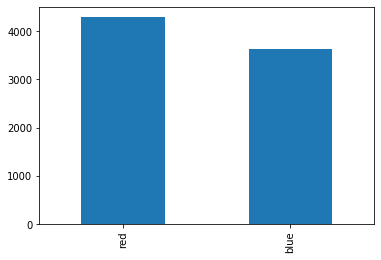

In [19]:
#Aufteilung in 1950 bis 1970 und 2016
colors = []
for x in dfs.year:
    if x == 2016:
        colors.append('red')
    elif (x <= 1970) & (x >= 1940):
        colors.append('blue')
    else: 
        colors.append('white')
dfs['colors']=colors
      
dfs_clean = dfs[dfs.colors != 'white']
pd.value_counts(dfs_clean.colors).plot.bar() 
pd.value_counts(dfs_clean.colors)

# K-Means mit TF-IDF

In [20]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
tokens = tfidf.fit_transform(dfs_clean.text)
#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(df_split.text)

In [21]:
tokens.toarray(), tokens.shape

(array([[0.        , 0.00723328, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00237341, 0.        , ..., 0.        , 0.00590788,
         0.        ],
        [0.        , 0.        , 0.00727558, ..., 0.        , 0.00903509,
         0.        ],
        ...,
        [0.        , 0.00611408, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]), (7930, 10000))

In [22]:
models = KMeans(n_clusters=2)
models.fit(tokens)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
len(models.labels_)

7930

In [24]:
tokens

<7930x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 7862670 stored elements in Compressed Sparse Row format>

C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

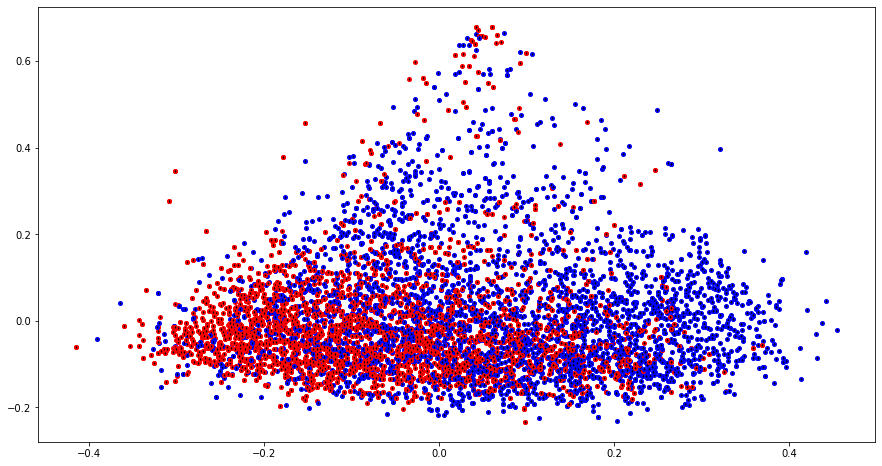

In [25]:
pca = PCA(n_components=2)
pca.fit(tokens.todense())
X_tf = pca.transform(tokens.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_clean['pcatokens_1'] = X_tf[:,0]
dfs_clean['pcatokens_2'] = X_tf[:,1]
dfs_clean['kmeanstokens'] = models.labels_

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_clean.iterrows():
    x = d[1].pcatokens_1
    y = d[1].pcatokens_2    
    plt.plot(x, y, 'o', markersize=4, color= d[1].colors)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens}'), color='black', markersize=1)

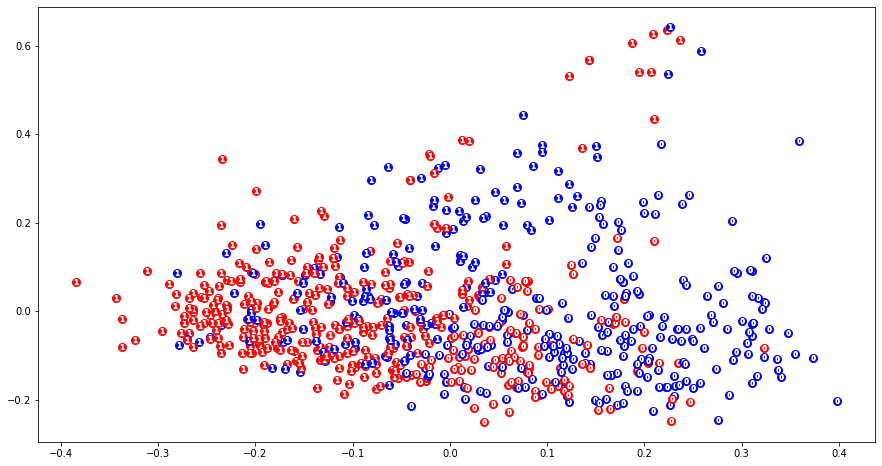

In [26]:
dfs_cleans = dfs_clean.sample(frac=0.1)

tfidf = TfidfVectorizer(max_features=10000)
tokens2 = tfidf.fit_transform(dfs_cleans.text)

pca = PCA(n_components=2)
pca.fit(tokens2.todense())
X_tf = pca.transform(tokens2.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_cleans['pcatokens_1'] = X_tf[:,0]
dfs_cleans['pcatokens_2'] = X_tf[:,1]

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_cleans.iterrows():
    x = d[1].pcatokens_1
    y = d[1].pcatokens_2    
    plt.plot(x, y, 'o', markersize=8, color= d[1].colors)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens}'), color='white', markersize=6)

## Ergebnisverteilung

In [27]:
b1 = dfs_cleans.loc[(dfs_cleans['kmeanstokens'] == 1) & (dfs_cleans['colors'] == 'blue')]
b0 = dfs_cleans.loc[(dfs_cleans['kmeanstokens'] == 0) & (dfs_cleans['colors'] == 'blue')]
r1 = dfs_cleans.loc[(dfs_cleans['kmeanstokens'] == 1) & (dfs_cleans['colors'] == 'red')]
r0 = dfs_cleans.loc[(dfs_cleans['kmeanstokens'] == 0) & (dfs_cleans['colors'] == 'red')]
print('b1: ', len(b1), 'b0: ', len(b0), 'r1: ', len(r1), 'r0: ', len(r0))

b1:  153 b0:  223 r1:  303 r0:  114


# 3. Cluster

## Slicing 3 Cluster Datensatz

blue     1940
red      1906
green    1827
Name: colors, dtype: int64

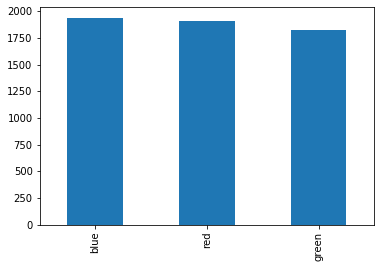

In [28]:
#Aufteilung in bis 1960, 1980 bis 1985 und 2017
colors = []
for x in dfs.year:
    if x <= 1960:
        colors.append('red')
    elif (x <= 1985) & (x >= 1980):
        colors.append('blue')
    elif x == 2017:
        colors.append('green')
    else: 
        colors.append('white')
dfs['colors']=colors
      
dfs_clean3 = dfs[dfs.colors != 'white']
pd.value_counts(dfs_clean3.colors).plot.bar() 
pd.value_counts(dfs_clean3.colors)

## K-Means

In [29]:
tfidf = TfidfVectorizer(max_features=10000)
tokens3 = tfidf.fit_transform(dfs_clean3.text)

In [30]:
models3 = KMeans(n_clusters=3)
models3.fit(tokens3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

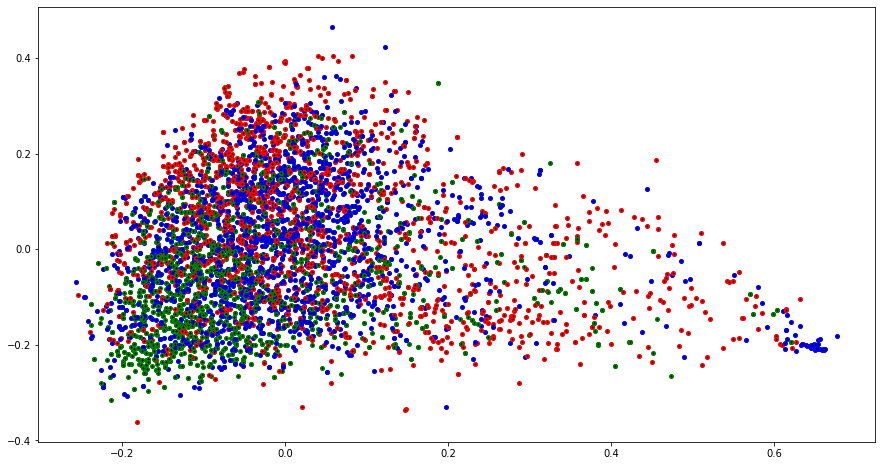

In [31]:
pca = PCA(n_components=2)
pca.fit(tokens3.todense())
X_tf = pca.transform(tokens3.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_clean3['pcatokens3_1'] = X_tf[:,0]
dfs_clean3['pcatokens3_2'] = X_tf[:,1]
dfs_clean3['kmeanstokens3'] = models3.labels_

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_clean3.iterrows():
    x = d[1].pcatokens3_1
    y = d[1].pcatokens3_2    
    plt.plot(x, y, 'o', markersize=4, color= d[1].colors)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens3}'), color='black', markersize=1)

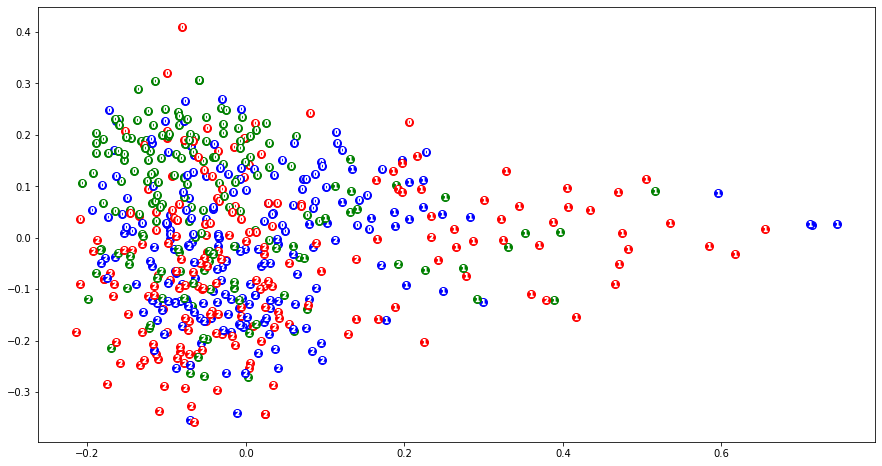

In [33]:
dfs_cleansample3 = dfs_clean3.sample(frac=0.1)

tfidf = TfidfVectorizer(max_features=10000)
tokens3c = tfidf.fit_transform(dfs_cleansample3.text)

pca = PCA(n_components=2)
pca.fit(tokens3c.todense())
X_tf = pca.transform(tokens3c.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_cleansample3['pcatokens3_1'] = X_tf[:,0]
dfs_cleansample3['pcatokens3_2'] = X_tf[:,1]

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_cleansample3.iterrows():
    x = d[1].pcatokens3_1
    y = d[1].pcatokens3_2    
    plt.plot(x, y, 'o', markersize=8, color= d[1].colors)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens3}'), color='white', markersize=6)

In [45]:
b1 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 1) & (dfs_cleansample3['colors'] == 'blue')]
b0 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 0) & (dfs_cleansample3['colors'] == 'blue')]
b2 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 2) & (dfs_cleansample3['colors'] == 'blue')]
r1 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 1) & (dfs_cleansample3['colors'] == 'red')]
r0 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 0) & (dfs_cleansample3['colors'] == 'red')]
r2 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 2) & (dfs_cleansample3['colors'] == 'red')]
g0 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 0) & (dfs_cleansample3['colors'] == 'green')]
g1 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 1) & (dfs_cleansample3['colors'] == 'green')]
g2 = dfs_cleansample3.loc[(dfs_cleansample3['kmeanstokens3'] == 2) & (dfs_cleansample3['colors'] == 'green')]
print('b1: ', len(b1), 'b0: ', len(b0), 'r1: ', len(r1), 'r0: ', len(r0))
print('    0 - 1 - 2 \ng: ', len(g0), len(g1), len(g2), '\nb: ', len(b0), len(b1), len(b2), '\nr: ', len(r0), len(r1), len(r2))

b1:  22 b0:  79 r1:  41 r0:  48
    0 - 1 - 2 
g:  105 18 48 
b:  79 22 102 
r:  48 41 104


## Hierarchisches Clustering

blue    33
red     30
Name: colors, dtype: int64

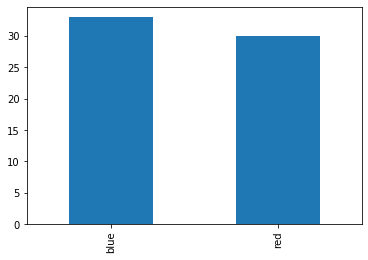

In [124]:
# 1940-1970 und 2016
dfs_clean.shape
# Datensatz samplen
dfs_cleans = dfs_clean.sample(frac=0.008)
pd.value_counts(dfs_cleans.colors).plot.bar() 
pd.value_counts(dfs_cleans.colors)

In [126]:
tfidf = TfidfVectorizer(max_features=10000)
dfs_cleans_tfids = tfidf.fit_transform(dfs_cleans.text)

hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(dfs_cleans_tfids.todense())

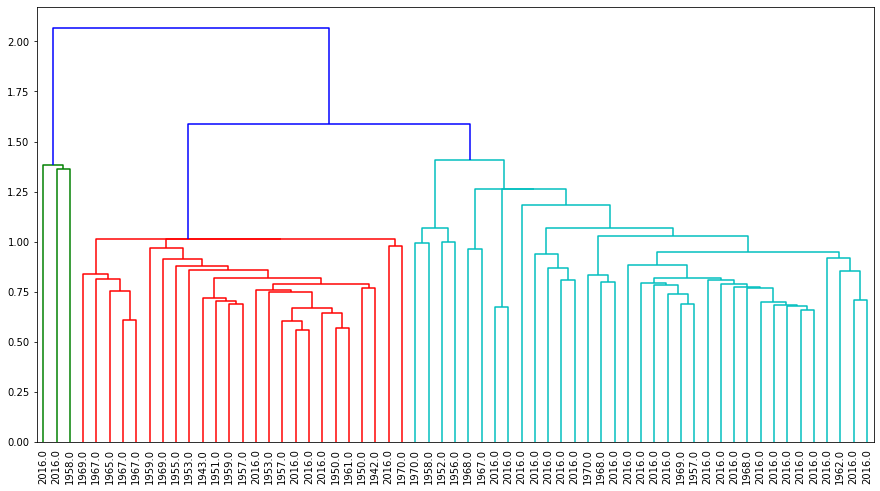

In [128]:
lmatrix = linkage_matrix(dfs_cleans_tfids.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=dfs_cleans['year'].values, leaf_font_size=10); #

Hellblau: 35, davon 23 mit Label 2016 und 12 mit Label zwischen 1940-1970 ---
Rot: 25, davon 5 mit Label 2016 und 20 mit Label zwischen 1940-1970 ---
Grün: 4, 2 mal 2016 und 1 mit Label zwischen 1940-1970

# Cluster mit zwei Variablen Zeit und Genre

In [ ]:
dfs.dropna(subset=['text', 'year', 'genre', 'duration', 'runtimeMinutes'], inplace=True)
plt.figure(figsize=(15,8))
pd.value_counts(dfs['year']).plot.bar()
dfs.shape

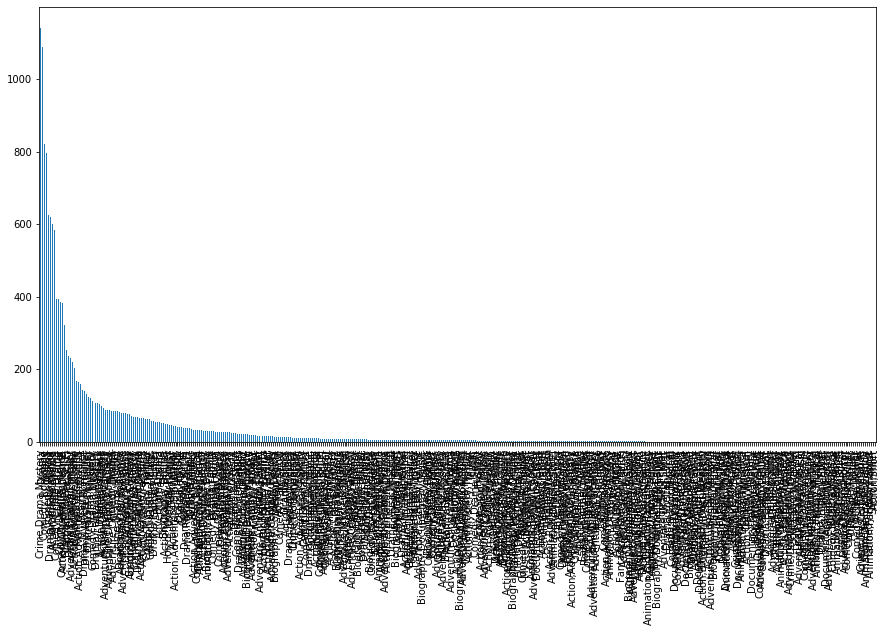

In [5]:
plt.figure(figsize=(15,8))
pd.value_counts(dfs['genre']).plot.bar()

red     56
blue    34
Name: labelcolor2var, dtype: int64

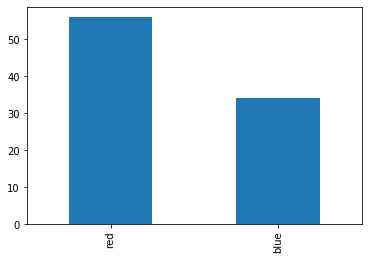

In [100]:
#Drama und horror bei 2017 und 2007
labelcolor2var = []
for index, row in dfs.iterrows():
    if (row['genre'] == 'Drama') & (row['year'] == 2017) == True:
        labelcolor2var.append('red')    #red
    elif (row['genre'] == 'Drama') & (row['year'] == 2007) == True:
        labelcolor2var.append('white') #orange
    elif (row['genre'] == 'Comedy') & (row['year'] == 2017) == True:
        labelcolor2var.append('blue')   #blue
    elif (row['genre'] == 'Comedy') & (row['year'] == 2007) == True:
        labelcolor2var.append('white')  #green
    else: 
        labelcolor2var.append('white')
dfs['labelcolor2var']=labelcolor2var    
        
dfs_2var = dfs[dfs.labelcolor2var != 'white']
pd.value_counts(dfs_2var.labelcolor2var).plot.bar() 
pd.value_counts(dfs_2var.labelcolor2var)      

## KMeans 2 Variablen Zeit und Genre

In [101]:
#tf-idf
tfidf = TfidfVectorizer(max_features=10000)
tokens_2var = tfidf.fit_transform(dfs_2var.text)

In [102]:
#KMeans
model_2var = KMeans(n_clusters=4)
model_2var.fit(tokens_2var)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

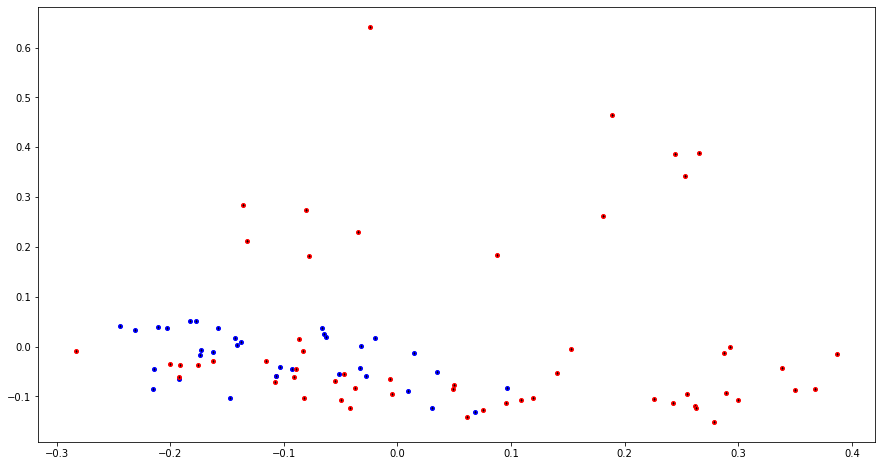

In [103]:
pca = PCA(n_components=2)
pca.fit(tokens_2var.todense())
X_tf = pca.transform(tokens_2var.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_2var['pca2var1'] = X_tf[:,0]
dfs_2var['pca2var2'] = X_tf[:,1]
dfs_2var['kmeans2var'] = model_2var.labels_

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_2var.iterrows():
    x = d[1].pca2var1
    y = d[1].pca2var2    
    plt.plot(x, y, 'o', markersize=4, color= d[1].labelcolor2var)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeans2var}'), color='black', markersize=1)

## hierarchisches Clustering mit 2 Variablen Zeit und Genre

In [104]:
#tf-idf
tfidf = TfidfVectorizer(max_features=10000)
tokens_2var = tfidf.fit_transform(dfs_2var.text)

In [105]:
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens_2var.todense())

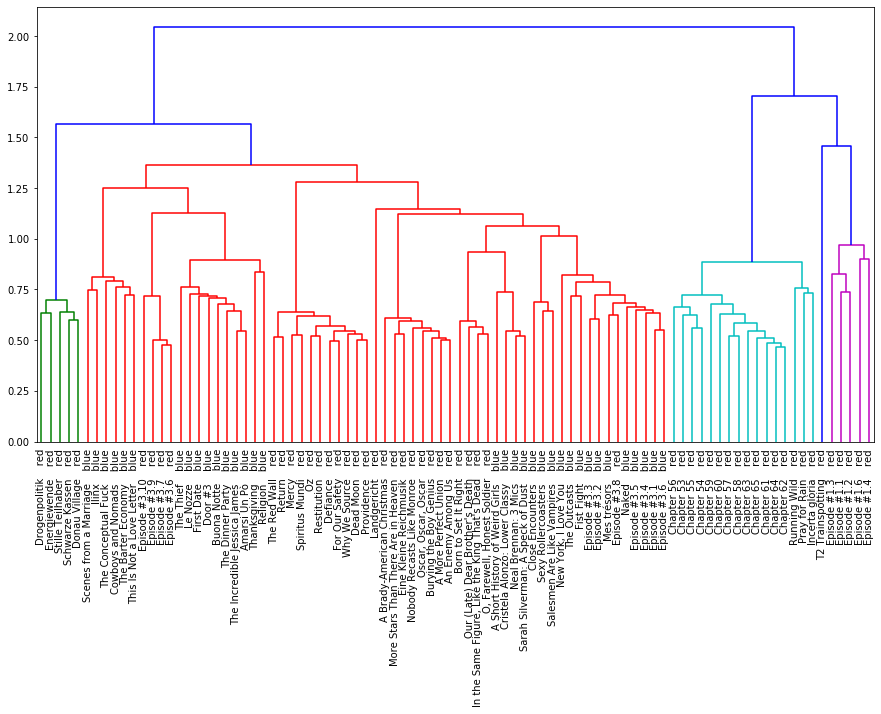

In [111]:
lmatrix = linkage_matrix(tokens_2var.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(dfs_2var['originalTitle'].values + '    ' + dfs_2var['labelcolor2var'].values), leaf_font_size=10);

In [96]:
# Blue ist Comedy, 2017 und rot ist Drama, 2017 ; orange ist Drama 2007 ; green ist Comedy 2007

## ohne Serien

In [4]:
dfs.dropna(subset=['text', 'year', 'genre', 'duration', 'runtimeMinutes'], inplace=True)
dfs_movie = dfs.loc[dfs['titleType'] == 'movie']

plt.figure(figsize=(15,8))
from collections import Counter
genre_combination_frequs = Counter(dfs_movie.genre)
genre_combination_frequs.most_common(50)

#pd.value_counts(dfs_movie['genre']).plot.bar()


[('Drama', 396),
 ('Comedy', 198),
 ('Drama,Romance', 142),
 ('Comedy,Drama', 142),
 ('Comedy,Drama,Romance', 119),
 ('Horror', 95),
 ('Comedy,Romance', 87),
 ('Horror,Thriller', 79),
 ('Drama,Thriller', 77),
 ('Action,Crime,Drama', 71),
 ('Documentary', 69),
 ('Crime,Drama,Thriller', 65),
 ('Adventure,Animation,Comedy', 65),
 ('Action,Crime,Thriller', 54),
 ('Thriller', 53),
 ('Action,Adventure,Sci-Fi', 46),
 ('Action,Comedy,Crime', 43),
 ('Action,Adventure,Drama', 41),
 ('Action', 39),
 ('Crime,Drama', 38),
 ('Biography,Drama', 35),
 ('Crime,Drama,Mystery', 33),
 ('Biography,Drama,History', 32),
 ('Action,Thriller', 31),
 ('Horror,Mystery,Thriller', 30),
 ('Action,Adventure,Fantasy', 30),
 ('Comedy,Horror', 28),
 ('Action,Adventure,Comedy', 28),
 ('Comedy,Crime,Drama', 27),
 ('Family', 22),
 ('Crime,Thriller', 22),
 ('Action,Horror,Sci-Fi', 22),
 ('Action,Adventure,Animation', 21),
 ('Action,Drama,History', 21),
 ('Biography,Drama,Romance', 20),
 ('Action,Comedy', 20),
 ('Action,Sci-

<Figure size 1080x576 with 0 Axes>

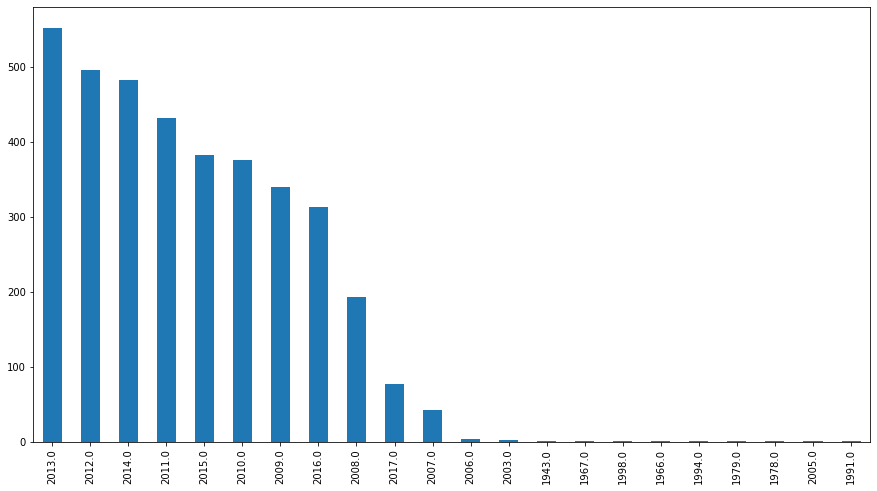

In [5]:
plt.figure(figsize=(15,8))
pd.value_counts(dfs_movie['year']).plot.bar()

blue    71
red     69
Name: labelcolor2var, dtype: int64

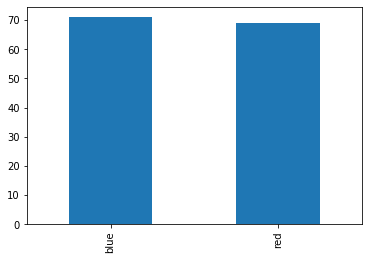

In [6]:
#Drama und horror bei 2017 und 2007
labelcolor2var = []
for index, row in dfs_movie.iterrows():
    if (row['genre'] == 'Documentary') == True:
        labelcolor2var.append('red')    #red
    elif (row['genre'] == 'Drama,Romance') & (row['year'] == 2007) == True:
        labelcolor2var.append('white') #orange
    elif (row['genre'] == 'Action,Crime,Drama') == True:
        labelcolor2var.append('blue')   #blue
    elif (row['genre'] == 'Horror') & (row['year'] == 2007) == True:
        labelcolor2var.append('white')  #green
    else: 
        labelcolor2var.append('white')
dfs_movie['labelcolor2var']=labelcolor2var    
dfs_movie = dfs_movie.loc[dfs_movie['originalTitle'] != 'Geisha vs ninja'] 
dfs_movie = dfs_movie.loc[dfs_movie['originalTitle'] != 'Dao jiàn xiào'] 
dfs_2var = dfs_movie[dfs_movie.labelcolor2var != 'white']
pd.value_counts(dfs_2var.labelcolor2var).plot.bar() 
pd.value_counts(dfs_2var.labelcolor2var)   

In [77]:
#tf-idf
tfidf = TfidfVectorizer(max_features=1000) #, stop_words=get_stop_words('de'))
tokens_2var = tfidf.fit_transform(dfs_2var.text)
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens_2var.todense())

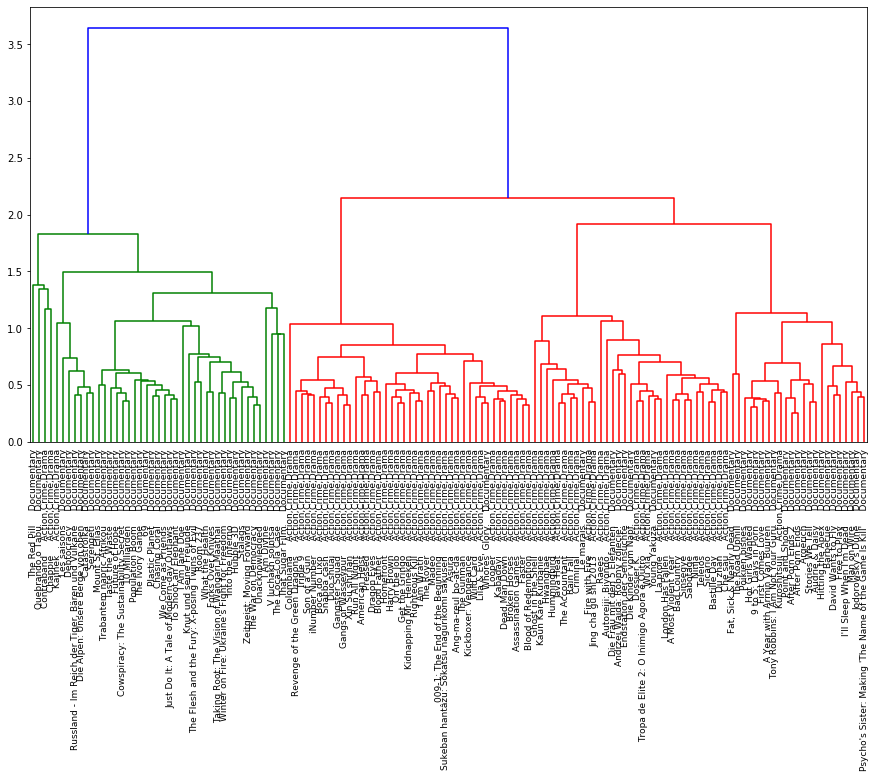

In [78]:
lmatrix = linkage_matrix(tokens_2var.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(dfs_2var['originalTitle'].values + "     " + dfs_2var['genre'].values), leaf_font_size=9);

## Documentary word counts

In [100]:
documentary = ""
for film in dfs_movie.iterrows():
    if film[1].genre == "Documentary":
        documentary = documentary + film[1].text

docu_tokens = re.findall("\w+", documentary.lower())
print(docu_tokens)
count_docu = Counter(docu_tokens).most_common(20)
count_docu

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[('ich', 13573),
 ('die', 13254),
 ('und', 12953),
 ('das', 9465),
 ('der', 8553),
 ('es', 8294),
 ('sie', 8055),
 ('ist', 7999),
 ('in', 6265),
 ('nicht', 6093),
 ('zu', 5896),
 ('wir', 5875),
 ('ein', 4338),
 ('er', 4211),
 ('den', 3866),
 ('war', 3736),
 ('mit', 3522),
 ('dass', 3484),
 ('von', 3424),
 ('eine', 3414)]

## Word count by moviename

In [130]:
dfs_bytitle = dfs_movie.loc[dfs_movie['originalTitle'] == 'Contraband']
text=""
for film in dfs_bytitle.iterrows():
    text = text + film[1].text
title_tokens = re.findall("\w+", text.lower())
title_docu = Counter(title_tokens).most_common(20)
title_docu
#Quebrando o Tabu
#dfs_bytitle.head()
text

'Wer ist der Chef Ihres Ingenieursbüros ? Ist es sein erster Arbeitstag ? Oder war er betrunken ? Und Sie ? Haben Sie geschlafen ? Ich bitte um Verzeihung . Stellen Sie sicher dass das nie wieder vorkommt ! Ja . Gut . Gut . Holt den Van . Nach links ! Gonzalo . Chris Farraday sucht dich . Bringt sie her . Ja Boss . Stopf ihm das Maul ! Auf gehts . Mir nach . Das hier ist Truck 220 . Wir werden aufgehalten . Lass mich mal sehen . Ja das ist der richtige . Wir müssen es aus dem Rahmen nehmen . Hey , Beeilung , die Polizei . Bringt den Pickup hierüber ! Bringt den Pickup ! Bringt ihn her verdammt nochmal ! Position halten , lasst keinen erkommen . Bewegung ! Bewegung Gruppe D , E und F sind spät dran . Ruf den Chefauseher . Sag ihm sie müssen sich beeilen , ein anderes Schiff wartet bereits . Gonzalo ist zurück ! Schnell macht das Tor auf ! Los , lass uns verschwinden . '

## Action, Crime, Drama word counts

In [99]:
acd = ""
for film in dfs_movie.iterrows():
    if film[1].genre == "Action,Crime,Drama":
        acd = acd + film[1].text

acd_tokens = re.findall("\w+", acd.lower())
count_acd = Counter(acd_tokens).most_common(20)
count_acd

[('ich', 13684),
 ('sie', 9778),
 ('du', 8812),
 ('ist', 7873),
 ('das', 7744),
 ('die', 6862),
 ('nicht', 6508),
 ('und', 5649),
 ('es', 5121),
 ('was', 4949),
 ('der', 4685),
 ('wir', 4310),
 ('er', 4065),
 ('zu', 3276),
 ('ein', 3254),
 ('in', 3176),
 ('ja', 3099),
 ('mir', 2749),
 ('den', 2674),
 ('auf', 2668)]

In [80]:
wordfreq = []
for film in dfs_movie.iterrows():
    tokens = re.findall("\w+", film[1].text.lower())
    count = Counter(tokens).most_common(10)
    #print(film[1].primaryTitle + ":  ", count)
    wordfreq.append(count)
dfs_movie['wordfreq']=wordfreq
dfs_movie.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,filename,text,IMDB_ID,genre,year,production_region,corpus,...,endYear,runtimeMinutes,averageRating,numVotes,mean_sentence_length,type_token_ratio,text_length,originalTitleLang,labelcolor2var,wordfreq
1043,1043,1043,34636,4638791.xml,""" Römische Nahrungsmittelkrise - Tausende wart...",tt1372686,"Drama,Thriller,War",2011.0,English,untokenisiert,...,NaN,123.0,6.1,30426.0,9.193939,0.256473,8535,en,white,"[(ich, 233), (und, 199), (er, 154), (es, 146),..."
2014,2014,2014,41932,5742601.xml,Ich kenne den Mann . Mit dem mache ich diverse...,tt1800241,"Crime,Drama",2013.0,"English, Arabic",untokenisiert,...,NaN,138.0,7.2,435871.0,7.172360,0.179325,14365,en,white,"[(ich, 605), (das, 386), (sie, 329), (ist, 307..."
2825,2825,2825,47700,6775012.xml,"18 Jahre später Du bist noch so jung , Jordyn ...",tt3233972,"Fantasy,Horror,Sci-Fi",2014.0,English,untokenisiert,...,NaN,80.0,2.6,506.0,6.821429,0.294118,2363,en,white,"[(du, 101), (ich, 94), (es, 73), (ist, 69), (n..."
2263,2263,2263,42926,4974525.xml,"Es war einmal vor langer Zeit , da lebte tief ...",tt2381962,"Action,Adventure,Horror",2013.0,English,untokenisiert,...,NaN,83.0,2.5,1670.0,7.445575,0.269406,5720,en,white,"[(du, 163), (ich, 151), (ist, 116), (die, 111)..."
436,436,436,28279,4413003.xml,"- Komm , Daniel ! Komm ! - Hallo , Chef ! Wir ...",tt1255956,Drama,2009.0,Norwegian,untokenisiert,...,NaN,110.0,6.4,608.0,5.757720,0.254448,3541,en,white,"[(du, 154), (ich, 113), (nicht, 88), (ist, 82)..."


## GMM

In [40]:
#tf-idf
tfidf = TfidfVectorizer(max_features=1000)
tokens_2var = tfidf.fit_transform(dfs_2var.text)
gmm = mixture.GaussianMixture(n_components=2, covariance_type='diag')
gmm_label = gmm.fit_predict(tokens_2var.toarray())
gmm.converged_

True

In [41]:
gmm_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\janko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

Comedy, Crime, Drama in rot VS Comedy, Horror in blau


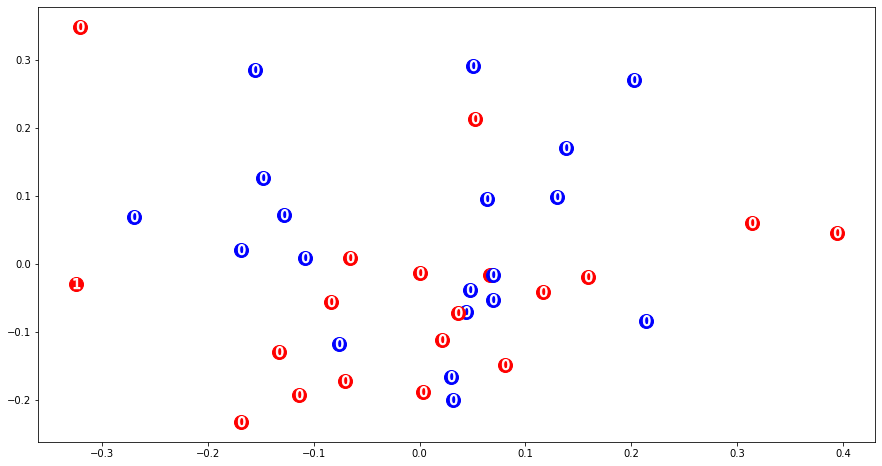

In [39]:
pca = PCA(n_components=2)
pca.fit(tokens_2var.todense())
X_tf = pca.transform(tokens_2var.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs_2var['gmm1'] = X_tf[:,0]
dfs_2var['gmm2'] = X_tf[:,1]
dfs_2var['gmmlabel'] = gmm_label
print('Comedy, Crime, Drama in rot VS Comedy, Horror in blau')
#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_2var.iterrows():
    x = d[1].gmm1
    y = d[1].gmm2    
    plt.plot(x, y, 'o', markersize=14, color= d[1].labelcolor2var)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].gmmlabel}'), color='white', markersize=12)